<img src="images/deep_neural_network.png" style="width:1024px;height:768px;">

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

# Initialize

## Without Dropout

In [ ]:
def initialize_parameters(layers_config):
    """
    Wl - weight matrix of shape (layer_dims[l], layer_dims[l-1])\n
    bl - bias vector of shape (layer_dims[l], 1)
    :param layer_dims: array (list) containing the dimensions of each layer
    :return: dictionary containing the parameters of each layer: "W1", "b1", ..., "WL", "bL
    """
    L = len(layers_config) - 1 # Number of hidden layers and output layer
    parameters = {"L": L}
    for l in range(1, L+1):
        curr, prev = layers_config[l], layers_config[l-1]
        dimsP = prev["dims"]
        dimsC, activC = curr["dims"], curr["activation"]

        # Initialize all weights using "He"/"Xavier" initialization to eliminate vanishing/exploding gradients
        if activC == "relu":
            parameters['W' + str(l)] = np.random.randn(dimsC, dimsP) * np.sqrt(2 / dimsP)
        elif activC == "sigmoid":
            parameters['W' + str(l)] = np.random.randn(dimsC, dimsP) * np.sqrt(1 / dimsP)
        else:
            parameters['W' + str(l)] *= 0.01

        # Initialize all biases to zero
        parameters['b' + str(l)] = np.zeros((dimsC, 1))
    return parameters

In [ ]:
np.random.seed(1)
t_parameters = initialize_parameters([
	{"dims": 5, "activation": "none"},
	{"dims": 4, "activation": "relu"},
	{"dims": 3, "activation": "relu"},
])

print(t_parameters["W1"])
print(t_parameters["W2"])
print(t_parameters["b1"])
print(t_parameters["b2"])

assert np.allclose(t_parameters["W1"], np.array([
    [1.02732621, -0.38690873, -0.33404515, -0.67860494, 0.54733184],
    [-1.45562088, 1.10351585, -0.48142952, 0.20177804,-0.15771567],
    [0.92471825, -1.30294739, -0.20391454, -0.2428973, 0.71705876],
    [-0.69563232, -0.10905317, -0.55520641, 0.02669832, 0.36860471]
]))
assert np.allclose(t_parameters["b1"], np.array(
    [0, 0, 0, 0]
))
assert np.allclose(t_parameters["W2"], np.array([
    [-0.77825528, 0.8094419, 0.63752091, 0.35531715],
    [ 0.63700135, -0.48346861, -0.08689651, -0.66168891],
    [-0.18942548, 0.37501795, -0.48907801, -0.28054711]
]))
assert np.allclose(t_parameters["b2"], np.array([[0.]]))

## With Dropout

In [ ]:
def initialize_parameters_dropout(layers_config):
    L = len(layers_config) - 1 # Number of hidden layers and output layer
    parameters = {"L": L}
    for l in range(1, L+1):
        curr, prev = layers_config[l], layers_config[l-1]
        dimsP = prev["dims"]
        dimsC, keep_probC, activC = curr["dims"], curr["keep_prob"], curr["activation"]

        # Initialize all weights using "He"/"Xavier" initialization to eliminate vanishing/exploding gradients
        if activC == "relu":
            parameters['W' + str(l)] = np.random.randn(dimsC, dimsP) * np.sqrt(2 / dimsP)
        elif activC == "sigmoid":
            parameters['W' + str(l)] = np.random.randn(dimsC, dimsP) * np.sqrt(1 / dimsP)
        else:
            parameters['W' + str(l)] *= 0.01

        # Initialize all biases to zero
        parameters['b' + str(l)] = np.zeros((dimsC, 1))
        # Initialize keep probability
        parameters['keep_prob' + str(l)] = keep_probC
    return parameters

# Forward propagation

## Common

In [ ]:
def sigmoid(Z):
    """
    Implements the sigmoid activation
    :param Z: numpy array of any shape
    :return: output of sigmoid(z), same shape as Z
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [ ]:
def relu(Z):
    """
    Implement the RELU function
    :param Z: Output of the linear layer, of any shape
    :return:  output of relu(z), same shape as Z
    """
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

In [ ]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.
    :param A: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :return:
        Z -- the input of the activation function, also called pre-activation parameter
        cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

In [ ]:
np.random.seed(1)
t_A = np.random.randn(3,2)
t_W = np.random.randn(1,3)
t_b = np.random.randn(1,1)
t_Z, t_linear_cache = linear_forward(t_A, t_W, t_b)
assert np.allclose(t_Z, np.array([3.26295337, -1.23429987]))

## Linear Forward (without dropout)

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :return:
        A -- the output of the activation function, also called the post-activation value
        cache -- a python tuple containing "linear_cache" and "activation_cache";
    """
    A, linear_cache, activation_cache = None, None, None
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

In [ ]:
np.random.seed(1)
t_A_prev = np.random.randn(3,2)
t_W = np.random.randn(1,3)
t_b = np.random.randn(1,1)
t_A, t_linear_activation_cache = linear_activation_forward(t_A_prev, t_W, t_b, activation = "sigmoid")
assert np.allclose(t_A, np.array([[0.96313579, 0.22542973]]));
t_A, t_linear_activation_cache = linear_activation_forward(t_A_prev, t_W, t_b, activation = "relu")
assert np.allclose(t_A, np.array([[3.26295337, 0.0]]));

In [ ]:
def forward_propagate(X, parameters):
    caches = []
    A = X
    L = parameters["L"] # Number of layers in the NN

    # Implement [LINEAR->RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    return AL, caches

In [ ]:
np.random.seed(1)
t_X = np.random.randn(5,4)
t_parameters = {
    "L": 3,
    "W1": np.random.randn(4,5),
    "b1": np.random.randn(4,1),
    "W2": np.random.randn(3,4),
    "b2": np.random.randn(3,1),
    "W3": np.random.randn(1,3),
    "b3": np.random.randn(1,1)
}
t_AL, t_caches = forward_propagate(t_X, t_parameters)
print("AL = " + str(t_AL))
assert np.allclose(t_AL, np.array([[0.77634609, 0.9998399, 0.99021857, 0.33755508]]))

## Linear Forward (with dropout)

In [ ]:
def linear_activation_forward_dropout(A_prev, W, b, keep_prob, activation):
    A, linear_cache, activation_cache = None, None, None

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    D = None
    if keep_prob < 1.0:
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = np.multiply(A, D)
        A = A / keep_prob

    cache = (linear_cache, activation_cache, D)
    return A, cache

In [ ]:
def forward_propagate_dropout(X, parameters):
    caches = []
    A = X
    L = parameters["L"] # Number of layers in the neural network

    # Implement [LINEAR->RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        W, b, keep_prob = parameters['W' + str(l)], parameters['b' + str(l)], parameters['keep_prob' + str(l)]
        A, cache = linear_activation_forward_dropout(A_prev, W, b, keep_prob, activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    WL, bL, keep_probL = parameters['W' + str(L)], parameters['b' + str(L)], parameters['keep_prob' + str(L)]
    AL, cache = linear_activation_forward_dropout(A, WL, bL, keep_probL, activation = "sigmoid")
    caches.append(cache)

    return AL, caches

# Cost function

In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function
    :param AL: probability vector corresponding to label predictions, shape (1, number of examples)
    :param Y: true "label" vector
    :return: cross-entropy cost
    """
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost

In [ ]:
t_Y = np.asarray([[1, 1, 0]])
t_AL = np.array([[0.8, 0.9, 0.4]])
t_cost = compute_cost(t_AL, t_Y)
assert np.allclose(t_cost, 0.2797765635793422)

# Backward propagation

## Common

In [ ]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [ ]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [ ]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [ ]:
np.random.seed(1)
t_dZ = np.random.randn(3,4)
t_linear_cache = (np.random.randn(5,4), np.random.randn(3,5), np.random.randn(3,1))
t_dA_prev, t_dW, t_db = linear_backward(t_dZ, t_linear_cache)
assert np.allclose(t_dA_prev, np.array([
    [-1.15171336, 0.06718465, -0.3204696, 2.09812712],
    [ 0.60345879, -3.72508701, 5.81700741, -3.84326836],
    [-0.4319552, -1.30987417, 1.72354705, 0.05070578],
    [-0.38981415, 0.60811244, -1.25938424, 1.47191593],
    [-2.52214926, 2.67882552, -0.67947465, 1.48119548],
]))
assert np.allclose(t_dW, np.array([
    [0.07313866, -0.0976715, -0.87585828, 0.73763362, 0.00785716],
    [0.85508818, 0.37530413, -0.59912655, 0.71278189, -0.58931808],
    [0.97913304, -0.24376494, -0.08839671, 0.55151192, -0.10290907],
]))
assert np.allclose(t_db, np.array([
    [-0.14713786],
    [-0.11313155],
    [-0.13209101]
]))

## Linear Backward (no dropout)

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def linear_activation_backward_dropout(dA, cache, activation):
    linear_cache, activation_cache, _ = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [ ]:
np.random.seed(2)
t_dAL = np.random.randn(1,2)
t_A = np.random.randn(3,2)
t_W = np.random.randn(1,3)
t_b = np.random.randn(1,1)
t_Z = np.random.randn(1,2)
t_linear_activation_cache = ((t_A, t_W, t_b), t_Z)

t_dA_prev, t_dW, t_db = linear_activation_backward(t_dAL, t_linear_activation_cache, activation = "sigmoid")
assert np.allclose(t_dA_prev, np.array([
    [0.11017994, 0.01105339],
    [0.09466817, 0.00949723],
    [-0.05743092, -0.00576154]
]))
assert np.allclose(t_dW, np.array([
    [0.10266786, 0.09778551, -0.01968084]
]))
assert np.allclose(t_db, np.array([
    [-0.05729622]
]))

t_dA_prev, t_dW, t_db = linear_activation_backward(t_dAL, t_linear_activation_cache, activation = "relu")
assert np.allclose(t_dA_prev, np.array([
    [0.44090989, 0.0],
    [0.37883606, 0.0],
    [-0.2298228, 0.0]
]))
assert np.allclose(t_dW, np.array([
    [0.44513824, 0.37371418, -0.10478989]
]))
assert np.allclose(t_db, np.array([
    [-0.20837892]
]))

In [ ]:
def backward_propagate(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [ ]:
np.random.seed(3)

t_AL = np.random.randn(1, 2)
t_Y = np.array([[1, 0]])

t_A1 = np.random.randn(4, 2)
t_W1 = np.random.randn(3,4)
t_b1 = np.random.randn(3,1)
t_Z1 = np.random.randn(3,2)
t_linear_cache_activation1 = ((t_A1, t_W1, t_b1), t_Z1)

t_A2 = np.random.randn(3,2)
t_W2 = np.random.randn(1,3)
t_b2 = np.random.randn(1,1)
t_Z2 = np.random.randn(1,2)
t_linear_cache_activation2 = ((t_A2, t_W2, t_b2), t_Z2)

t_AL, t_Y_assess, t_caches = t_AL, t_Y, (t_linear_cache_activation1, t_linear_cache_activation2)
t_grads = backward_propagate(t_AL, t_Y_assess, t_caches)

assert np.allclose(t_grads['dA0'], np.array([
    [0.0, 0.52257901],
    [0.0, -0.3269206],
    [0.0, -0.32070404],
    [0.0, -0.74079187]
]))
assert np.allclose(t_grads['dA1'], np.array([
    [0.12913162, -0.44014127],
    [-0.14175655, 0.48317296],
    [0.01663708, -0.05670698]
]))
assert np.allclose(t_grads['dW1'], np.array([
    [0.41010002, 0.07807203, 0.13798444, 0.10502167],
    [0.0, 0.0, 0.0, 0.0],
    [0.05283652, 0.01005865, 0.01777766, 0.0135308 ],
]))
assert np.allclose(t_grads['dW2'], np.array([
    [-0.39202432, -0.13325855, -0.04601089]
]))
assert np.allclose(t_grads['db1'], np.array([
    [-0.22007063],
    [0.0],
    [-0.02835349]
]))
assert np.allclose(t_grads['db2'], np.array([
    [0.15187861]
]))

## Linear Backward (with dropout)

In [ ]:
def backward_propagate_dropout(AL, Y, parameters, caches):
    grads = {}
    L = parameters["L"] # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    keep_probL = parameters["keep_prob" + str(L)]
    if keep_probL < 1.0:
        _, _, D = caches[L-1]
        dAL = np.multiply(dAL, D)
        dAL = dAL / keep_probL

    curr_cache = caches[L-1]
    dA_prev, dW, db = linear_activation_backward_dropout(dAL, curr_cache, activation = "sigmoid")
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = (dA_prev, dW, db)

    for l in reversed(range(L-1)):
        curr_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward_dropout(grads["dA" + str(l+1)], curr_cache, activation = "relu")
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = (dA_prev, dW, db)

    for l in reversed(range(1, L)):
        keep_prob = parameters["keep_prob" + str(l)]
        if keep_prob < 1.0:
            _, _, D = caches[l-1]
            dAl = grads["dA" + str(l)]
            dAl = np.multiply(dAl, D)
            dAl = dAl / keep_prob
            grads["dA" + str(l)] = dAl

    return grads

# Update parameters

## Update parameters (without dropout)

In [ ]:
def update_parameters(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    L = parameters["L"]
    v_corrected = {}
    s_corrected = {}
    for l in range(1, L+1):
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads['dW' + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads['db' + str(l)]
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1-np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1-np.power(beta1, t))
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*np.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*np.square(grads['db' + str(l)])
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1-np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1-np.power(beta2, t))
        parameters["W" + str(l)] -= learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] -= learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))
    return parameters, v, s, v_corrected, s_corrected

In [ ]:
np.random.seed(2)
t_W1 = np.random.randn(3,4)
t_b1 = np.random.randn(3,1)
t_W2 = np.random.randn(1,3)
t_b2 = np.random.randn(1,1)
t_parameters = {"W1": t_W1,
                "b1": t_b1,
                "W2": t_W2,
                "b2": t_b2}

np.random.seed(3)
t_dW1 = np.random.randn(3,4)
t_db1 = np.random.randn(3,1)
t_dW2 = np.random.randn(1,3)
t_db2 = np.random.randn(1,1)
t_grads = {"dW1": t_dW1,
           "db1": t_db1,
           "dW2": t_dW2,
           "db2": t_db2}
t_parameters = update_parameters(t_parameters, t_grads, 0.1)

assert np.allclose(t_parameters["W1"], np.array([
    [-0.59562069, -0.09991781, -2.14584584, 1.82662008],
    [-1.76569676, -0.80627147, 0.51115557, -1.18258802],
    [-1.0535704, -0.86128581, 0.68284052, 2.20374577]
]))
assert np.allclose(t_parameters["b1"], np.array([
    [-0.04659241],
    [-1.28888275],
    [0.53405496]
]))
assert np.allclose(t_parameters["W2"], np.array([
    [-0.55569196, 0.0354055, 1.32964895]
]))
assert np.allclose(t_parameters["b2"], np.array([
    [-0.84610769]
]))

## Update parameters (with dropout)

In [ ]:
def update_parameters_dropout(parameters, grads, learning_rate):
    L = parameters["L"]
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

## Load data

In [ ]:
import h5py
from common import CV_DATA_DIR

In [ ]:
def load_data():
    train_dataset = h5py.File(CV_DATA_DIR / "playground" / "dnn" / "train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(CV_DATA_DIR / "playground" / "dnn" / "test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [ ]:
print ("Number of training examples:", train_x_orig.shape[0])
print ("Number of testing examples:", test_x_orig.shape[0])
print ("Each image is of size: (" + str(train_x_orig.shape[1]) + ", " + str(train_x_orig.shape[1]) + ", 3)")

assert train_x_orig.shape == (209, 64, 64, 3)
assert train_y.shape == (1, 209)
assert test_x_orig.shape == (50, 64, 64, 3)
assert test_y.shape == (1, 50)

In [ ]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

# Train L-layer model

## Common

In [62]:
def get_mini_batches(X, Y, mini_batch_size=64, seed=1):
    m = X.shape[1]
    mini_batches = []

    # Shuffle (X,Y)
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [ ]:
def initialize_adam(parameters):
    """
    Initialize v and s
        - keys: "dW1", "db1", ..., "dWL", "dbL"
        - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    """
    L = parameters["L"]
    v = {}
    s = {}
    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    return v, s

In [ ]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.

    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar
    """
    learning_rate = learning_rate0 / (1 + decay_rate * epoch_num)
    return learning_rate

In [ ]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.

    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar
    """
    learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num/time_interval))
    return learning_rate

## Train L-layer Model (without dropout)

In [105]:
learning_rate = 0.0007

# NN layers configuration (input layer + hidden layers + output layer)
layers_config = [
	{"dims": 12288, "activation": None},
	{"dims": 20, "activation": "relu"},
	{"dims": 7, "activation": "relu"},
	{"dims": 5, "activation": "relu"},
	{"dims": 1, "activation": "sigmoid"},
]

In [106]:
def L_layer_model(X, Y, layers_config, learning_rate = 0.001, num_epochs = 3500, decay_rate=1, print_cost=False):
    # Set start learning rate
    learning_rate0 = learning_rate

    # Initialize NN parameters
    parameters = initialize_parameters(layers_config)
    # Initialize the optimizer parameters
    v, s = initialize_adam(parameters)

    t = 0
    seed = 10
    costs = []

    for i in range(0, num_epochs):
        # Forward propagation
        AL, caches = forward_propagate(X, parameters)
        # Compute cost
        cost = compute_cost(AL, Y)
        # Backward propagation
        grads = backward_propagate(AL, Y, caches)
        # Update parameters
        t = t + 1
        parameters, v, s, _, _ = update_parameters(parameters, grads, v, s, t, learning_rate)
        # Update learning rate
        learning_rate = schedule_lr_decay(learning_rate0, i, decay_rate)
        # Stora cost values to plot
        if i % 100 == 0:
            costs.append(cost)
        # Print cost value
        if print_cost and (i % 100 == 0 or i == num_epochs - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))

    return parameters, costs

In [115]:
parameters, costs = L_layer_model(
    train_x,
    train_y,
    layers_config,
    learning_rate=learning_rate,
    num_epochs=3000,
    print_cost = True)

Cost after iteration 0: 0.692679777968078
Cost after iteration 100: 0.3513411718572191
Cost after iteration 200: 0.25870642905979385
Cost after iteration 300: 0.2281714745548866
Cost after iteration 400: 0.17829990667323362
Cost after iteration 500: 0.14218844909152487
Cost after iteration 600: 0.1083592841070296
Cost after iteration 700: 0.07604753678388523
Cost after iteration 800: 0.04771361154576466
Cost after iteration 900: 0.035018645506220795
Cost after iteration 1000: 0.029982037809414313
Cost after iteration 1100: 0.02855193693725117
Cost after iteration 1200: 0.02755985262985629
Cost after iteration 1300: 0.02687895967734289
Cost after iteration 1400: 0.026394581320925623
Cost after iteration 1500: 0.02606927214007504
Cost after iteration 1600: 0.025840901668327414
Cost after iteration 1700: 0.025666375437617017
Cost after iteration 1800: 0.025562104175944206
Cost after iteration 1900: 0.025490643439223436
Cost after iteration 2000: 0.02543184756242884
Cost after iteration 21

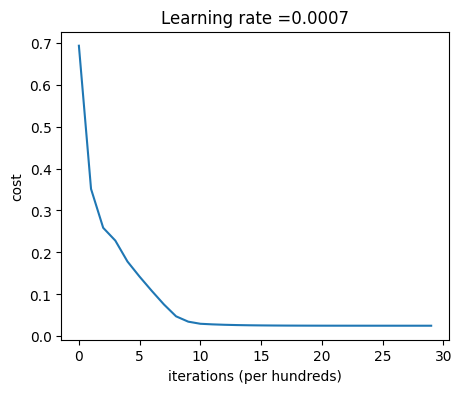

In [116]:
plot_costs(costs, learning_rate)

## Train L-layer Model (with dropout)

In [ ]:
learning_rate = 0.01

layers_config_dropout = [
	{"dims": 12288, "keep_prob": 1.0, "activation": None},
	{"dims": 20, "keep_prob": 0.935, "activation": "relu"},
	{"dims": 7, "keep_prob": 0.97, "activation": "relu"},
	{"dims": 5, "keep_prob": 1.0, "activation": "relu"},
	{"dims": 1, "keep_prob": 1.0, "activation": "sigmoid"},
]

In [ ]:
def L_layer_model_dropout(X, Y, layers, learning_rate = 0.0075, num_iterations = 3500, print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_dropout(layers)
    for i in range(0, num_iterations):
        AL, caches = forward_propagate_dropout(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backward_propagate_dropout(AL, Y, parameters, caches)
        parameters = update_parameters_dropout(parameters, grads, learning_rate)
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
    return parameters, costs

In [ ]:
parameters_dropout, costs_dropout = L_layer_model_dropout(
    train_x, train_y,
    layers_config_dropout,
    num_iterations = 4500,
    print_cost = True)

In [ ]:
plot_costs(costs_dropout, learning_rate)

# Test

# Prediction (without dropout)

In [ ]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    p = np.zeros((1,m))

    probas, caches = forward_propagate(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    accuracy = np.sum((p == y) / m)
    return p, accuracy

In [ ]:
_, accuracy = predict(train_x, train_y, parameters)
print("Accuracy (train):", accuracy)
_, accuracy = predict(test_x, test_y, parameters)
print("Accuracy (test):", accuracy)

# Prediction (with dropout)

In [ ]:
def predict_dropout(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    p = np.zeros((1,m))

    probas, caches = forward_propagate_dropout(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    accuracy = np.sum((p == y) / m)
    return p, accuracy

In [ ]:
_, accuracy_dropout = predict_dropout(train_x, train_y, parameters_dropout)
print("Accuracy (train):", accuracy_dropout)
_, accuracy_dropout = predict_dropout(test_x, test_y, parameters_dropout)
print("Accuracy (test):", accuracy_dropout)

# Gradient Checking

Backpropagation computes the gradients $\frac{\partial J}{\partial \theta}$, where $\theta$ denotes the parameters of the model. $J$ is computed using forward propagation and loss function.

Definition of a derivative (or gradient):$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon}$$

For each i in parameters:
- Compute `J_p[i]`:
    1. Set $\theta^{+}$ to `np.copy(param_values)`
    2. Set $\theta^{+}_i$ to $\theta^{+}_i + \varepsilon$
    3. Calculate $J^{+}_i$ using to `forward_propagate(X, vec_to_dic(`$\theta^{+}$`, param_shapes))`.
- To compute `J_m[i]`: do the same thing with $\theta^{-}$
- Compute $gradapprox[i] = \frac{J^{+}_i - J^{-}_i}{2 \varepsilon}$

Where gradapprox[i] is an approximation of the gradient with respect to `param_values[i]`. Then comparing gradapprox vector with the gradients vector from backpropagation the difference can be received:
$$ difference = \frac {\| grad - gradapprox \|_2}{\| grad \|_2 + \| gradapprox \|_2 } \tag{3}$$

$10^{-7}$ or less is good, $10^{-5}$ need to double-check components, $10^{-3}$ - need to worry.

In [ ]:
def dic_to_vec(parameters):
    theta = []
    shapes = {}
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"]:
        shapes[key] = parameters[key].shape
        new_vector = np.reshape(parameters[key], (-1, 1))
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1
    return theta, shapes

In [ ]:
def vec_to_dic(param_values, param_shapes):
    output = {}
    offset = 0
    for key,shape in param_shapes.items():
        items = shape[0] * shape[1]
        output[key] = param_values[offset:offset+items].reshape(shape)
        offset += items
    return output

In [ ]:
def grad_to_vec(gradients):
    theta = []
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3", "dW4", "db4"]:
        new_vector = np.reshape(gradients[key], (-1, 1))
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count += 1
    return theta

In [ ]:
def gradient_check(parameters, gradients, X, Y, N=100, epsilon=1e-7):
    L = parameters["L"]
    param_values, param_shapes = dic_to_vec(parameters)
    grads = grad_to_vec(gradients)

    No = param_values.shape[0]
    J_p = np.zeros((No, 1))
    J_m = np.zeros((No, 1))
    gradapproxs = np.zeros((No, 1))

    assert N <= No, \
        "N parameter is invalid"

    for i in range(N):
        theta_p = np.copy(param_values)
        theta_p[i] = theta_p[i] + epsilon
        param_p = vec_to_dic(theta_p, param_shapes)
        param_p["L"] = L
        Yp_hat, _ = forward_propagate(X, param_p)
        J_p[i] = compute_cost(Yp_hat, Y)

        theta_m = np.copy(param_values)
        theta_m[i] = theta_m[i] - epsilon
        param_m = vec_to_dic(theta_m, param_shapes)
        param_m["L"] = L
        Ym_hat, _ = forward_propagate(X, param_m)
        J_m[i] = compute_cost(Ym_hat, Y)

        gradapproxs[i] = (J_p[i] - J_m[i]) / (2 * epsilon)

    num = np.linalg.norm(grads[:N] - gradapproxs[:N])
    den = np.linalg.norm(grads[:N]) + np.linalg.norm(gradapproxs[:N])
    differences = num / den
    return differences


In [ ]:
parameters = initialize_parameters(layers_config)
AL, caches = forward_propagate(train_x, parameters)
gradients = backward_propagate(AL, train_y, caches)

difference = gradient_check(parameters, gradients, train_x, train_y)
print("Difference:", difference)